In [1]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import random_split
import pytorch_lightning as pl
import torch
from torch import nn
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel
%load_ext tensorboard
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
class GetFullDF:
    def __init__(self):
        self.df = None
    def __call__(self):
        if self.df is None:
            df = pd.concat([
#                 pd.read_csv(os.path.join('/scratch/mcinerney.de/metaicl/results_loss_not_normalized/results_gpt2meta', 'results.csv')),
#                 pd.read_csv(os.path.join('/scratch/mcinerney.de/metaicl/results_loss_not_normalized/results_gptj', 'results.csv')),
#                 pd.read_csv(os.path.join('/scratch/mcinerney.de/metaicl/results/results_gpt2meta/results.csv')),
#                 pd.read_csv(os.path.join('/scratch/mcinerney.de/metaicl/results/results_gptj', 'results.csv')),
#                 pd.read_csv('/scratch/mcinerney.de/metaicl/results/results_gpt2meta2/results_commonsense_qa.csv'),
#                 pd.read_csv('/scratch/mcinerney.de/metaicl/results/results_gpt2meta2/results_medical_questions_pairs.csv'),
                pd.read_csv('/scratch/mcinerney.de/metaicl/results/results_gpt2meta3/results_commonsense_qa.csv'),
            ])
            df = df.drop_duplicates(['task', 'train_data_split', 'train_indices', 'checkpoint'])
            df = df.reset_index()
            df['sampling'] = 'within_task_random'
            df['method'] = 'in_context'
            df['descriptor'] = df[['checkpoint', 'sampling', 'method']].apply(tuple, axis=1)
            df['logprob'] = -df['loss']
            df['prob'] = np.exp(-df['loss'])
            df['evaluated_on_size'] = df['evaluated_on'].apply(lambda x: len(eval(x)))
            df['normalizedlogprob'] = -df['normalized_loss']
            df['normalizedprob'] = np.exp(-df['normalized_loss'])
            self.df = df
        return self.df
get_full_df = GetFullDF()
def evaluate_prediction_dfs(train_df, val_df, key):
    print('train corr: %f, val corr: %f' % (
        train_df.regression_predictions.corr(train_df[key]),
        val_df.regression_predictions.corr(val_df[key])))
    chart = sns.scatterplot(data=train_df, x=key, y='regression_predictions', hue='task')
    plt.show()
    chart = sns.scatterplot(data=val_df, x=key, y='regression_predictions', hue='task')
    plt.show()

# Data

In [2]:
def get_breakdown(df):
    ckpts = sorted(list(set(df.checkpoint)))
    tasks = sorted(list(set(df.task)))
    samplings = sorted(list(set(df.sampling)))
    methods = sorted(list(set(df.method)))
    splits = list(set(df.train_data_split))
    evalsizes = list(set(df.evaluated_on_size))
    breakdown_df = pd.DataFrame({
        task: {
            (ch, sampling, method, split, evalsize): len(df[
                (df.task == task) & (df.checkpoint == ch) &
                (df.sampling == sampling) & (df.method == method) &
                (df.train_data_split == split) & (df.evaluated_on_size == evalsize)])
            for ch in ckpts for sampling in samplings for method in methods for split in splits for evalsize in evalsizes
        } for task in tasks}).transpose()
    print(len(breakdown_df))
    return breakdown_df
get_breakdown(get_full_df())

1


checkpoints/metaicl/hr_to_lr/model.pt     
                                  within_task_random     
                                          in_context     
                                               train  val
                                                 200  200
commonsense_qa                                  1128  100

1128
with logprob
acc corr 0.24831821590873773


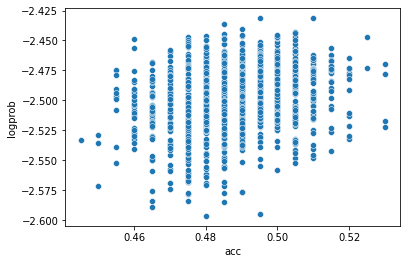

f1 corr 0.16903401604887855


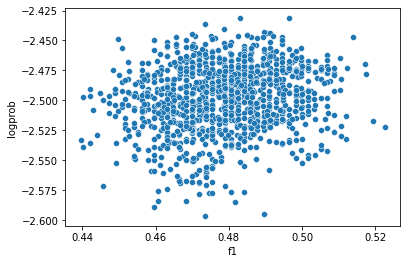

with prob
acc corr 0.24811058902845326


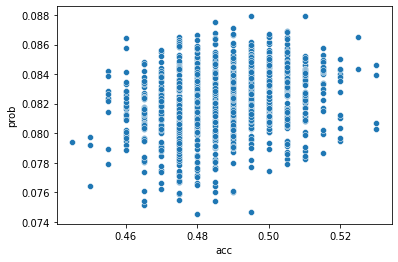

f1 corr 0.16874327208655285


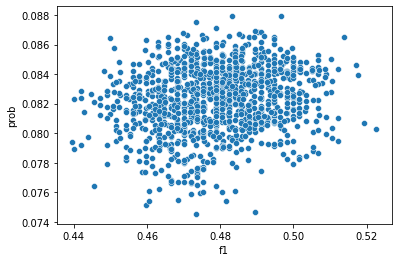

with normalized logprob
acc corr 0.4170747771314225


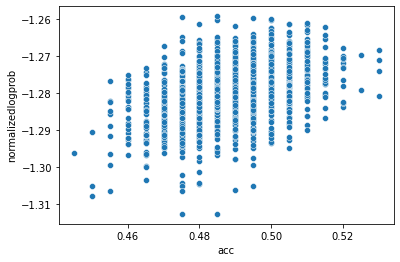

f1 corr 0.39389136426052235


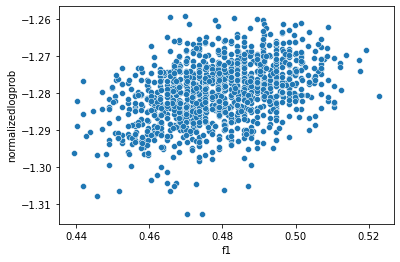

with normalized prob
acc corr 0.4171312201811203


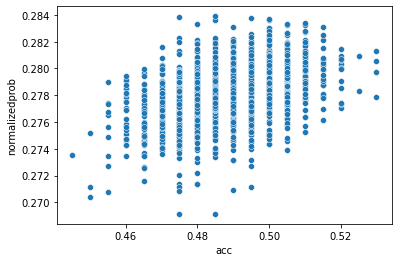

f1 corr 0.39394880191080556


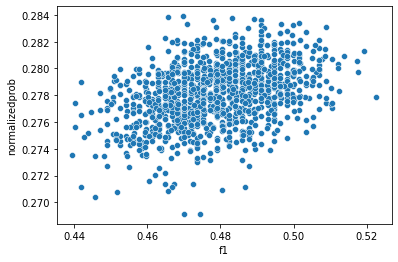

In [3]:
df = get_full_df()
df = df[
    (df.checkpoint == 'checkpoints/metaicl/hr_to_lr/model.pt') &
    (df.task == 'commonsense_qa') &
    (df.train_data_split == 'train')
]
print(len(df))
print('with logprob')
print('acc corr', df.logprob.corr(df.acc))
sns.scatterplot(data=df, x='acc', y='logprob')
plt.show()
print('f1 corr', df.logprob.corr(df.f1))
sns.scatterplot(data=df, x='f1', y='logprob')
plt.show()
print('with prob')
print('acc corr', df.prob.corr(df.acc))
sns.scatterplot(data=df, x='acc', y='prob')
plt.show()
print('f1 corr', df.prob.corr(df.f1))
sns.scatterplot(data=df, x='f1', y='prob')
plt.show()
print('with normalized logprob')
print('acc corr', df.normalizedlogprob.corr(df.acc))
sns.scatterplot(data=df, x='acc', y='normalizedlogprob')
plt.show()
print('f1 corr', df.normalizedlogprob.corr(df.f1))
sns.scatterplot(data=df, x='f1', y='normalizedlogprob')
plt.show()
print('with normalized prob')
print('acc corr', df.normalizedprob.corr(df.acc))
sns.scatterplot(data=df, x='acc', y='normalizedprob')
plt.show()
print('f1 corr', df.normalizedprob.corr(df.f1))
sns.scatterplot(data=df, x='f1', y='normalizedprob')
plt.show()

In [4]:
def get_prompt(train_samples):
    train_samples = eval(train_samples)
    return '\n\n'.join(['input: %s\noutput: %s\n' % (dp['input'], dp['output']) for dp in train_samples])
class PromptPerformanceDataset(Dataset):
    def __init__(self, df, key):
        self.df = df
        self.key = key
    def __len__(self):
        return len(self.df)
    def __getitem__(self, index):
        row = self.df.iloc[index]
        return dict(
            prompt=get_prompt(row.train_samples),
            label=row[self.key],
        )
class PromptsPerformanceData(pl.LightningDataModule):
    def __init__(self, get_df_func, key='normalizedlogprob', train_percent=.8, val_percent=.1, seed=0, no_example_overlap=False,
                 **dataloader_kwargs):
        super().__init__()
        self.get_df_func = get_df_func
        self.dataloader_kwargs = dataloader_kwargs
        self._train, self._val, self._test = None, None, None
        self.train_percent, self.val_percent, self.seed = train_percent, val_percent, seed
        self.no_example_overlap = no_example_overlap
        self.key = key
    def setup(self, stage=None):
        df = self.get_df_func()
        df = df[df.k != 0]
        if self.no_example_overlap:
            self._train, self._val, self._test = [
                PromptPerformanceDataset(df[df.train_data_split == split], self.key)
                for split in ['train', 'val', 'test']]
        else:
            df = df[df.train_data_split == 'train']
            length = len(df)
            train_length = int(length * self.train_percent)
            val_length = int(length * self.val_percent)
            lengths = [train_length, val_length, length - train_length - val_length]
            rows = [r for i, r in df.iterrows()]
            splits = random_split(rows, lengths, generator=torch.Generator().manual_seed(self.seed))
            self._train, self._val, self._test = [
                PromptPerformanceDataset(pd.DataFrame(list(x)), self.key) for x in splits]
    def train_dataloader(self):
        return DataLoader(self._train, **self.dataloader_kwargs, shuffle=True)
    def val_dataloader(self):
        return DataLoader(self._val, **self.dataloader_kwargs)
    def test_dataloader(self):
        return DataLoader(self._test, **self.dataloader_kwargs)

# Linear Regression on per-example Binary Variables

In [5]:
def get_features(indices):
    x = np.zeros(500)
    x[np.array(indices)] = 1
    return x
def getxy(df, key):
    X = np.stack(df.apply(lambda r: get_features(eval(r.train_indices)), axis=1))
    y = np.array(df[key])
    return X, y
def setup_and_train_linear_regression(task, checkpoint, key, save_coefs=False):
    def get_df():
        df = get_full_df()
        return df[(df.task == task) & (df.checkpoint == checkpoint)]
    dm = PromptsPerformanceData(get_df)
    dm.setup()
    X_train, y_train = getxy(dm._train.df, key)
    print('train shapes: X - %s, y - %s' % (str(X_train.shape), str(y_train.shape)))
    X_val, y_val = getxy(dm._val.df, key)
    print('val shapes: X - %s, y - %s' % (str(X_val.shape), str(y_val.shape)))
    model = sm.OLS(y_train, sm.add_constant(X_train)).fit()
#     print(model.summary())
#     model = LinearRegression()
#     model.fit(X_train, y_train)
    if save_coefs:
        if not os.path.exists('regcoef'):
            os.mkdir('regcoef')
        if not os.path.exists(os.path.join('regcoef', checkpoint.replace('/', '-'))):
            os.mkdir(os.path.join('regcoef', checkpoint.replace('/', '-')))
#         np.save(os.path.join('regcoef', checkpoint.replace('/', '-'), '%s.npy' % task), model.coef_)
        np.save(os.path.join('regcoef', checkpoint.replace('/', '-'), '%s.npy' % task), model.params[1:])
        if not os.path.exists('negregcoef'):
            os.mkdir('negregcoef')
        if not os.path.exists(os.path.join('negregcoef', checkpoint.replace('/', '-'))):
            os.mkdir(os.path.join('negregcoef', checkpoint.replace('/', '-')))
#         np.save(os.path.join('regcoef', checkpoint.replace('/', '-'), '%s.npy' % task), model.coef_)
        np.save(os.path.join('negregcoef', checkpoint.replace('/', '-'), '%s.npy' % task), -model.params[1:])
    return dm, model
def get_prediction_dfs_linear_regression(dm, model, key):
    X_train, y_train = getxy(dm._train.df, key)
#     y_train_pred = model.predict(X_train)
    y_train_pred = model.predict(sm.add_constant(X_train))
    train_df = dm._train.df.copy()
    train_df['regression_predictions'] = y_train_pred
    X_val, y_val = getxy(dm._val.df, key)
#     y_val_pred = model.predict(X_val)
    y_val_pred = model.predict(sm.add_constant(X_val))
    val_df = dm._val.df.copy()
    val_df['regression_predictions'] = y_val_pred
#     print('train regression score: %s, val regression score: %s' % (model.score(X_train, y_train), model.score(X_val, y_val)))
    return train_df, val_df

train shapes: X - (902, 500), y - (902,)
val shapes: X - (112, 500), y - (112,)
train corr: 0.942191, val corr: 0.849955


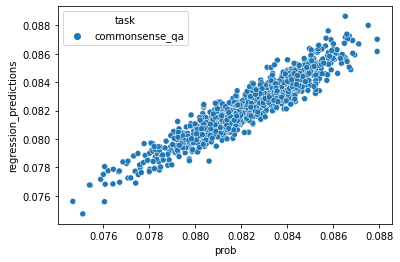

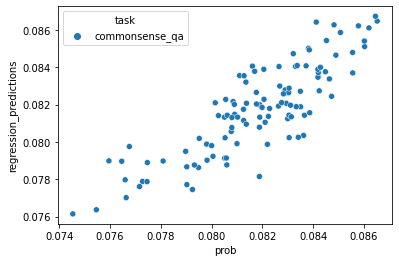

In [6]:
key = 'prob'
task = 'commonsense_qa'
# task = 'medical_questions_pairs'
dm, model = setup_and_train_linear_regression(
    task, 'checkpoints/metaicl/hr_to_lr/model.pt', key, save_coefs=True)
train_df, val_df = get_prediction_dfs_linear_regression(dm, model, key)
evaluate_prediction_dfs(train_df, val_df, key)

train shapes: X - (902, 500), y - (902,)
val shapes: X - (112, 500), y - (112,)
train corr: 0.878234, val corr: 0.515831


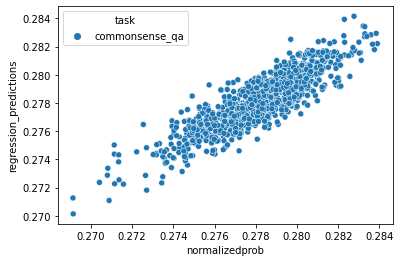

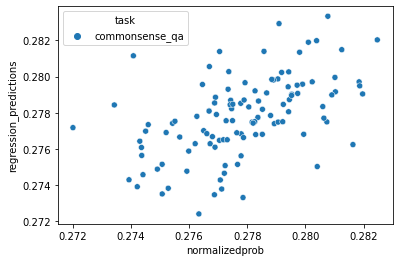

In [7]:
key = 'normalizedprob'
task = 'commonsense_qa'
# task = 'medical_questions_pairs'
dm, model = setup_and_train_linear_regression(
    task, 'checkpoints/metaicl/hr_to_lr/model.pt', key, save_coefs=True)
train_df, val_df = get_prediction_dfs_linear_regression(dm, model, key)
evaluate_prediction_dfs(train_df, val_df, key)

# Bert Regression

### Model

In [8]:
class StringRegressionModel(pl.LightningModule):
    def __init__(self, lr=1e-4):
        super().__init__()
        self.model = AutoModel.from_pretrained('roberta-base')
        self.linear = nn.Linear(768, 1)
        self.loss = nn.MSELoss()
        self.lr = lr
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)
    def forward(self, batch):
        out = self.model(**batch['text'])
        predictions = self.linear(out[1]).squeeze(-1)
        return predictions
    def shared_step(self, batch, step_type):
        predictions = self(batch)
        loss = self.loss(predictions, batch['label'])
        self.log('loss/%s' % step_type, loss.item())
        return loss
    def training_step(self, batch, batch_idx):
        return self.shared_step(batch, 'train')
    def validation_step(self, batch, batch_idx):
        return self.shared_step(batch, 'val')
    def test_step(self, batch, batch_idx):
        return self.shared_step(batch, 'test')
    def predict_step(self, batch, batch_idx):
        return self(batch).cpu().numpy()
class CollateFn:
    def __init__(self):
        self.tokenizer = AutoTokenizer.from_pretrained('roberta-base')
    def __call__(self, instances):
        return dict(
            text=self.tokenizer([self.tokenizer.cls_token + ' ' + i['prompt'] for i in instances], return_tensors='pt', padding=True, truncation=True),
            label=torch.tensor([i['label'] for i in instances], dtype=torch.float32)
        )
def setup_and_train_roberta_regression(task, checkpoint, key, epochs=10, batch_size=32, lr=1e-4, seed=0, no_example_overlap=False):
    def get_df():
        df = get_full_df()
        return df[(df.task == task) & (df.checkpoint == checkpoint)]
    dm = PromptsPerformanceData(get_df, key=key, batch_size=batch_size, collate_fn=CollateFn(), seed=seed,
                                no_example_overlap=no_example_overlap)
    dm.setup()
    model = StringRegressionModel(lr=lr)
    trainer = pl.Trainer(gpus=1, max_epochs=epochs, log_every_n_steps=10)
    trainer.fit(model, datamodule=dm)
    return trainer, dm, model
def get_prediction_dfs_roberta_regression(trainer, dm, model):
    train_reg_preds = np.concatenate(trainer.predict(model, dm.train_dataloader()))
    train_df = dm._train.df.copy()
    train_df['regression_predictions'] = train_reg_preds
    val_reg_preds = np.concatenate(trainer.predict(model, dm.val_dataloader()))
    val_df = dm._val.df.copy()
    val_df['regression_predictions'] = val_reg_preds
    return train_df, val_df

### Training and evaluating the model

In [9]:
# !kill 4849
%tensorboard --logdir=lightning_logs --port 6061

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /work/frink/mcinerney.de/metaicl/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type         | Params
---

/home/mcinerney.de/.conda/envs/metaicl/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 28 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/mcinerney.de/.conda/envs/metaicl/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 28 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/mcinerney.de/.conda/envs/metaicl/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:495: PossibleUserWarning: Your `predict_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(
/home/mcinerney.de/.conda/envs/metaicl/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 28 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/mcinerney.de/.conda/envs/metaicl/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 28 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(



train corr: 0.014534, val corr: 0.361645


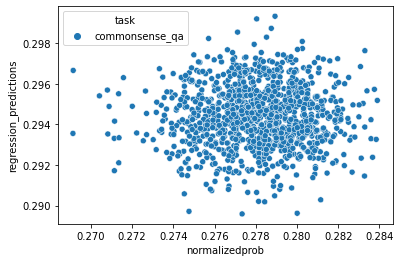

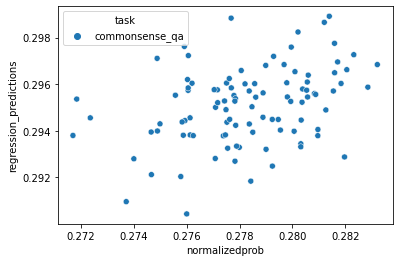

In [10]:
key = 'normalizedprob'
trainer, dm, model = setup_and_train_roberta_regression(
    'commonsense_qa', 'checkpoints/metaicl/hr_to_lr/model.pt', key, epochs=20, lr=1e-5, no_example_overlap=True)
train_df, val_df = get_prediction_dfs_roberta_regression(trainer, dm, model)
evaluate_prediction_dfs(train_df, val_df, key)

# Pairwise Ranking of Prompts

In [11]:
class StringPairRankingModel(pl.LightningModule):
    def __init__(self, lr=1e-4):
        super().__init__()
        self.model = AutoModel.from_pretrained('roberta-base')
        self.linear = nn.Linear(768, 768)
        self.activation = nn.ReLU()
#         self.loss = nn.MSELoss()
        self.lr = lr
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)
    def forward(self, batch):
        out = self.model(**batch['text'])
        vecs1 = self.activation(self.linear(out[1]))
        vecs2 = out[1]
        predictions = torch.mm(vecs1, vecs2.transpose(0, 1))
        predictions = F.logsigmoid(predictions)
        return predictions
    def shared_step(self, batch, step_type):
        predictions = self(batch)
        loss = -(predictions * batch['label']).sum()
        self.log('loss/%s' % step_type, loss.item())
        num_predictions = len(predictions) * (len(predictions) - 1)
        acc = (((torch.exp(predictions) > .5) * 2 - 1) == batch['label']).sum() / num_predictions
        self.log('acc/%s' % step_type, acc.item())
        return loss
    def training_step(self, batch, batch_idx):
        return self.shared_step(batch, 'train')
    def validation_step(self, batch, batch_idx):
        return self.shared_step(batch, 'val')
    def test_step(self, batch, batch_idx):
        return self.shared_step(batch, 'test')
    def predict_step(self, batch, batch_idx):
        return torch.exp(self(batch)).cpu().numpy()
class PairRankingCollateFn:
    def __init__(self):
        self.tokenizer = AutoTokenizer.from_pretrained('roberta-base')
    def __call__(self, instances):
        labels = []
        for i, i1 in enumerate(instances):
            labels.append([])
            for j, i2 in enumerate(instances):
                labels[-1].append(0 if i == j else 1 if i1['label'] > i2['label'] else -1)
        return dict(
            text=self.tokenizer([self.tokenizer.cls_token + ' ' + i['prompt'] for i in instances], return_tensors='pt', padding=True, truncation=True),
            label=torch.tensor(labels, dtype=torch.float32)
        )
def setup_and_train_roberta_pair_ranking(task, checkpoint, key, epochs=10, batch_size=32, lr=1e-4, seed=0, no_example_overlap=False):
    def get_df():
        df = get_full_df()
        return df[(df.task == task) & (df.checkpoint == checkpoint)]
    dm = PromptsPerformanceData(get_df, key=key, batch_size=batch_size, collate_fn=PairRankingCollateFn(),
                                seed=seed,
                                no_example_overlap=no_example_overlap)
    dm.setup()
    model = StringPairRankingModel(lr=lr)
    trainer = pl.Trainer(gpus=1, max_epochs=epochs, log_every_n_steps=10)
    trainer.fit(model, datamodule=dm)
    return trainer, dm, model
def evaluate_roberta_pair_ranking(trainer, dm, model):
    raise NotImplementedError

In [12]:
key = 'prob'
trainer, dm, model = setup_and_train_roberta_pair_ranking(
    'commonsense_qa', 'checkpoints/metaicl/hr_to_lr/model.pt', key, epochs=20, lr=1e-5, no_example_overlap=True)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type         | Params
--------------------------------------------
0 | model      | RobertaM

/home/mcinerney.de/.conda/envs/metaicl/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 28 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/mcinerney.de/.conda/envs/metaicl/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 28 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


# Per-example Correlation Coefficient Regression

For a given example, can we estimate how the correlation coefficient between including the example in the prompt and the score? If so, we would be able to estimate which examples are more positively correlated and use them in the prompt.

In [13]:
key = 'normalizedprob'
dm, model = setup_and_train_linear_regression('commonsense_qa', 'checkpoints/metaicl/hr_to_lr/model.pt', key)
print(model.params)

train shapes: X - (902, 500), y - (902,)
val shapes: X - (112, 500), y - (112,)
[0.18395216 0.00602001 0.00627244 0.00500497 0.00569486 0.00495225
 0.00642732 0.00515224 0.00647466 0.00512342 0.00617536 0.00513111
 0.00677157 0.00443817 0.00680976 0.00561499 0.00566606 0.00539538
 0.00597856 0.00473124 0.00683996 0.00568569 0.00504218 0.00682056
 0.0060437  0.00549733 0.0055948  0.00572132 0.00676681 0.00550935
 0.00663465 0.00560721 0.00502836 0.00463621 0.00528971 0.00577275
 0.00531239 0.00641461 0.00600588 0.00635741 0.00654388 0.00646959
 0.00685459 0.00582716 0.00534313 0.00793926 0.00674708 0.00572536
 0.00588526 0.00553507 0.00685512 0.00593913 0.00603231 0.00599997
 0.00691087 0.0061267  0.00613321 0.00648185 0.00637126 0.00544776
 0.00602876 0.00574373 0.00704432 0.00624877 0.00503686 0.00653865
 0.00640515 0.00522391 0.00630933 0.00570584 0.00621733 0.00541518
 0.00608416 0.00460923 0.00547265 0.00552735 0.00621185 0.00606768
 0.00601258 0.00698267 0.00480902 0.00597227 0.00

train shapes: X - (902, 500), y - (902,)
val shapes: X - (112, 500), y - (112,)


,task,input,output,options,coefficient
432,commonsense_qa,Where would works be on the wall?,art show,"[house or other building, art show, prison, cl...",0.005368
197,commonsense_qa,If you hit someone while driving what could ha...,may die,"[deaths, get arrested, moving, using gas, may ...",0.006351
388,commonsense_qa,What gets rid of a mundane routine?,new,"[sophisticated, imprevist, arcane, heavenly, new]",0.005546
455,commonsense_qa,What is the final phase of a living being's life?,death,"[decay, respiration, death, growing older, som...",0.005952
215,commonsense_qa,What do you need to do when you are getting dr...,consumption of alcohol,"[ethanol, consumption of alcohol, fall down, b...",0.005532
...,...,...,...,...,...
395,commonsense_qa,The football field was all ready for Friday ni...,high school,"[university, high school, city, college campus...",0.005689
466,commonsense_qa,"Tim flies airplanes, but not passenger planes....",carry freight,"[arrive late, teach, catch on fire, taxi, carr...",0.006531
457,commonsense_qa,What can you do in front of a tv if you have c...,see favorite show,"[search the web, go somewhere, read book, see ...",0.006896
53,commonsense_qa,Where is a student likely to have a ring binder?,school,"[school, notebook, book store, office, office ...",0.006911


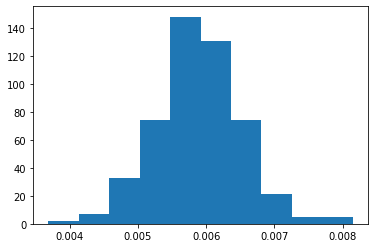

In [14]:
key = 'normalizedprob'
dm, model = setup_and_train_linear_regression('commonsense_qa', 'checkpoints/metaicl/hr_to_lr/model.pt', key)
plt.hist(model.params[1:])
df = get_full_df()
df = df[(df.task == 'commonsense_qa') & (df.checkpoint == 'checkpoints/metaicl/hr_to_lr/model.pt')]
examples_df = {}
for i, row in df.iterrows():
    for index, example in zip(eval(row.train_indices), eval(row.train_samples)):
        example['coefficient'] = model.params[index + 1]
        examples_df[index] = example
examples_df = pd.DataFrame(examples_df).transpose()
examples_df

train shapes: X - (902, 500), y - (902,)
val shapes: X - (112, 500), y - (112,)
[-0.84635086 -0.02659223 -0.02570152 -0.03025769 -0.0277387  -0.030443
 -0.02513362 -0.02971783 -0.02495876 -0.02981605 -0.02605621 -0.02981534
 -0.02388799 -0.03231023 -0.02371403 -0.0280474  -0.0278554  -0.02883214
 -0.02677301 -0.03124699 -0.02366258 -0.02779685 -0.03011815 -0.02371701
 -0.02651962 -0.02848531 -0.02813236 -0.02766014 -0.02394632 -0.02842577
 -0.02441987 -0.02808785 -0.03020496 -0.03161492 -0.02924197 -0.02752356
 -0.02913018 -0.02515348 -0.02666611 -0.02539053 -0.02470789 -0.02498348
 -0.02358481 -0.02731179 -0.02902988 -0.01968923 -0.02399341 -0.02768059
 -0.02707833 -0.0283648  -0.02357762 -0.02690069 -0.02654666 -0.02667909
 -0.02339775 -0.02620386 -0.02619436 -0.02496443 -0.02534059 -0.02869125
 -0.02654062 -0.02759305 -0.02291979 -0.02579769 -0.03013301 -0.02476557
 -0.02523    -0.02947875 -0.02557362 -0.02771228 -0.02589261 -0.02877025
 -0.02638782 -0.03170734 -0.02858495 -0.028405

,task,input,output,options,coefficient
432,commonsense_qa,Where would works be on the wall?,art show,"[house or other building, art show, prison, cl...",-0.028913
197,commonsense_qa,If you hit someone while driving what could ha...,may die,"[deaths, get arrested, moving, using gas, may ...",-0.02541
388,commonsense_qa,What gets rid of a mundane routine?,new,"[sophisticated, imprevist, arcane, heavenly, new]",-0.028296
455,commonsense_qa,What is the final phase of a living being's life?,death,"[decay, respiration, death, growing older, som...",-0.026852
215,commonsense_qa,What do you need to do when you are getting dr...,consumption of alcohol,"[ethanol, consumption of alcohol, fall down, b...",-0.028354
...,...,...,...,...,...
395,commonsense_qa,The football field was all ready for Friday ni...,high school,"[university, high school, city, college campus...",-0.02779
466,commonsense_qa,"Tim flies airplanes, but not passenger planes....",carry freight,"[arrive late, teach, catch on fire, taxi, carr...",-0.024756
457,commonsense_qa,What can you do in front of a tv if you have c...,see favorite show,"[search the web, go somewhere, read book, see ...",-0.02346
53,commonsense_qa,Where is a student likely to have a ring binder?,school,"[school, notebook, book store, office, office ...",-0.023398


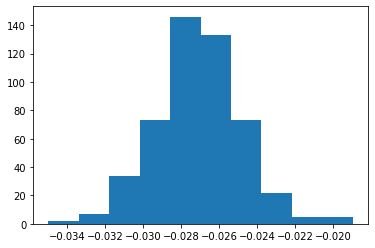

In [16]:
key = 'normalizedlogprob'
dm, model = setup_and_train_linear_regression('commonsense_qa', 'checkpoints/metaicl/hr_to_lr/model.pt', key)
print(model.params)
plt.hist(model.params[1:])
df = get_full_df()
df = df[(df.task == 'commonsense_qa') & (df.checkpoint == 'checkpoints/metaicl/hr_to_lr/model.pt')]
examples_df = {}
for i, row in df.iterrows():
    for index, example in zip(eval(row.train_indices), eval(row.train_samples)):
        example['coefficient'] = model.params[index + 1]
        examples_df[index] = example
examples_df = pd.DataFrame(examples_df).transpose()
examples_df

### Data